ML pipeline on toy regression problem

using sklearn_pandas.DataFrameMapper allows checking the column names after preprocessing / transformations

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import gen_features, DataFrameMapper, CategoricalImputer, FunctionTransformer

from utils.pandas_feature_union import PandasFeatureUnion
from utils import process as p
from utils import diagnosis as d

# load data

In [2]:
data_path = '../data/'
raw = pd.read_csv(data_path+'train.csv')
y = raw['SalePrice']
X = raw.copy()
cat_features, cont_features, dates = p.tidy_features_type()

In [3]:
# turn into a string to prevent error down the line
X['MSSubClass'] = X['MSSubClass'].astype(str)
X = p.transform_dates(X, dates)
cont_features.extend(['time_since_built', 'time_since_remod', 'time_since_garage'])
remove_cols = dates + ['date_sold', 'SalePrice', 'Id']
X = X.drop(remove_cols, 1)

print(f"check design matrix dimensions: {len(cat_features) + len(cont_features) + 1 == X.shape[1]}")

# outliers
index_outliers = (X.time_since_built < 0) | (X.time_since_garage < 0) | (X.time_since_remod < 0)
print("#outliers: ", index_outliers.sum())
X = X[np.logical_not(index_outliers)]
y = y[np.logical_not(index_outliers)]

check design matrix dimensions: True
#outliers:  1


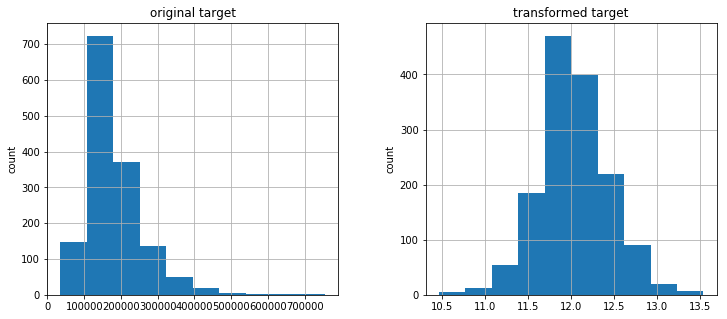

In [4]:
# we might want to transform the target variable to penalise tails less
target_transform = p.TargetTransform(np.log, np.exp).fit()
# target_transform = sklearn.preprocessing.PowerTransformer().fit(y)

transform_y = y.agg({'original target': lambda x:x,
                     'transformed target':target_transform.transform
                    }).unstack().T.hist(figsize=(12,5));
ax1, ax2 = transform_y[0].ravel()
ax1.set_ylabel('count');
ax2.set_ylabel('count');

In [5]:
# continuous features: impute nulls, scale 
transf_cont = gen_features(
    columns=[[c] for c in cont_features],
    classes=[{'class': SimpleImputer, 'strategy':'mean'}, 
             {'class': StandardScaler}
            ])

# categorical features: impute nulls, OHE
transf_cat = [([c], 
               [
                   CategoricalImputer(strategy='constant', fill_value='missing'), 
                   OneHotEncoder(handle_unknown='ignore', sparse=False)
               ]) 
              for c in cat_features]

# We may want to OHE where nulls were before imputing
# cat_features are imputed with "missing" value so no need to do that for them
ohe_nulls_features = cont_features.copy() 
transf_null = [
                ([c], [MissingIndicator(features="all"), 
                       FunctionTransformer(int)], 
                 {'alias':f"{c}_missing"}
                ) for c in ohe_nulls_features]

mapper_main = DataFrameMapper(transf_cont + transf_cat, input_df=True, df_out=True)
mapper_null = DataFrameMapper(transf_null, input_df=True, df_out=True)

preprocess = PandasFeatureUnion([('main', mapper_main), ('null', mapper_null)])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
preprocess.fit(X_train)
X_train = preprocess.transform(X_train)
X_test = preprocess.transform(X_test)

# feature selection / reduction

In [7]:
vthresh = p.VarianceThresh() # default: remove single values
vthresh.fit(X_train)
X_train = vthresh.transform(X_train)
X_test = vthresh.transform(X_test)

# pca = u.PCAColumns(10)
# pca.fit(X_train)
# pca.explain_variance(n=4)
# pca.get_loadings(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)             

# metrics

we could choose to penalise predictions that are below the ground truth differently e.g.

In [8]:
from sklearn.metrics import mean_absolute_error, make_scorer

def asym_mae_func(y_true, y_pred):
    diff = (y_pred - y_true)
    return np.mean(np.where(np.sign(diff) == -1, 1.05*np.abs(diff), np.abs(diff)))
asym_mae = make_scorer(asym_mae_func, greater_is_better=False)

or just select one of the out of the box available metrics

In [9]:
# list(sklearn.metrics.SCORERS.keys())
scoring = 'neg_mean_absolute_error' # as input to gridsearch
metric_name, metric_func = 'mean_absolute_error', mean_absolute_error

# gridsearch

In [10]:
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [11]:
# regr = ElasticNet(random_state=0)
# params = [{"l1_ratio": [0.3,0.5,0.7]
#           }]

regr = RandomForestRegressor(random_state=0)
params = [ {'n_estimators': [100,150,200],
            'max_depth':[2,5,7,10, None]
           }]

grid = GridSearchCV(regr, params, cv=3, iid=False, verbose=2, n_jobs=-1, 
                    return_train_score=True, scoring=scoring)
grid.fit(X_train, y_train);
final_regr = grid.best_estimator_
print("best parameters: ", grid.best_params_)
# grid.cv_results_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.2s finished


best parameters:  {'max_depth': None, 'n_estimators': 200}


In [12]:
y_pred_train, y_pred_test, df_perf = d.model_performance(final_regr, metric_func, X_train, X_test, 
                                                       y_train, y_test, pred_out=True)

In [13]:
baseline_estimator = DummyRegressor(strategy='mean')
df_baseline = d.model_performance(baseline_estimator, metric_func, X_train, X_test, 
                                                       y_train, y_test)
print(metric_func.__name__)
d.baseline_comparison(df_perf, df_baseline).round(2)

mean_absolute_error


,model,baseline,difference,uplift_percent
train,6565.64,57417.86,50852.22,88.57
test,17107.29,58318.28,41210.99,70.67


In [14]:
df_summary = d.df_regression_summary(y_train, y_test, y_pred_train, y_pred_test)
df_summary.head()

,actual,pred,sample,residuals,percent_delta
92,163500,151519.625,train,11980.375,7.327446
839,130500,128049.750,train,2450.250,1.877586
360,156000,151391.250,train,4608.750,2.954327
666,129000,149316.620,train,-20316.620,-15.749318
40,160000,157829.500,train,2170.500,1.356562


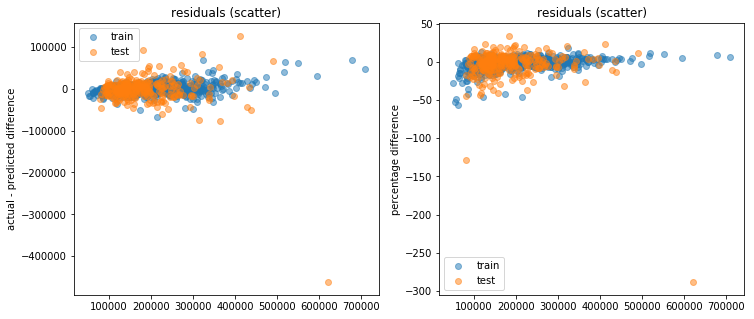

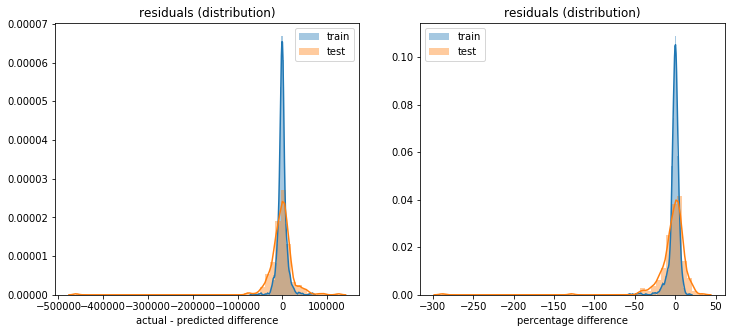

In [15]:
d.plot_residuals(df_summary, True)